## Wave equation with maximally dissipative boundary conditions

Arnau Duran Mayol

Elements de Relativitat Numèrica

UIB
## ADVECTION EQUATION

$\partial_tu+c\partial_xu=0$

Set $c=1$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [3]:
# Parameters
L = 10.0    # Length of the domain
T = 2    # Total simulation time
a = 1.0     # Advection velocity
Nx = 100    # Number of spatial grid points
Nt = 200    # Number of time steps
CFL = 0.9    # condition necessary for convergence
dx = 2*L / Nx  # Spatial step size
dt = CFL * dx
epsilon=1

# Initial condition with Gaussian
def initial_condition(x, A, sigma):
    return A * np.exp(-x**2 / (2 * sigma**2))

def boundary_conditions(u):
    u[0] = u[Nx - 4]
    u[1] = u[Nx - 3]
    u[Nx - 2] = u[2]
    u[Nx - 1] = u[3]
    return u

# Kreiss-Oliger dissipation term
def dissipation_term(u,dx,Nx, epsilon):
    Qd = np.zeros_like(u)  # Initialize Qd

    for i in range(Nx):
        Qd[i] = epsilon*1/(64*dx)*(u[(i+3)%Nx]-6*u[(i+2)%Nx]+15*u[(i+1)%Nx]-20*u[i]+15*u[(i-1)%Nx]-6*u[(i-2)%Nx]+u[(i-3)%Nx])
    return Qd

#Spatial derivative 4th order
def spatial_derivative_4_order(u,Nx,dx):
    rhs = np.zeros_like(u)
    for i in range(Nx):
        rhs[i] = -(-u[(i+2)%Nx]+8*u[(i+1)%Nx]-8*u[(i-1)%Nx]+u[(i-2)%Nx])/(12*dx)
    return rhs

def analytical_solution(x, t):
    return initial_condition(x - t, A, sigma)

# Initialize grid
x = np.linspace(-L, L, Nx, endpoint=False)
A = 1.0
sigma = 1
u = initial_condition(x, A, sigma)

#rk3 with 4th order D
def RK3(u, dx, dt, Nx):
    # Initialize arrays to store intermediate results
    u_new = np.zeros_like(u)
    u_temp = np.copy(u)
    rhs_un = np.zeros_like(u)
    rhs_u1 = np.zeros_like(u)
    rhs_u2 = np.zeros_like(u)
    # Compute the spatial derivative and dissipation term at the current time step
    rhs_un = spatial_derivative_4_order(u_temp, Nx, dx) + dissipation_term(u_temp,dx,Nx,epsilon)
    # First stage of RK3 method
    u1 = (u_temp + dt * rhs_un)
    u1 = boundary_conditions(u1)
    rhs_u1 = spatial_derivative_4_order(u1, Nx, dx)+ dissipation_term(u1,dx,Nx,epsilon)
    # Second stage of RK3 method
    u2 = (u_temp + dt * (rhs_un + rhs_u1) / 4) 
    u2 = boundary_conditions(u2)
    rhs_u2 = spatial_derivative_4_order(u2, Nx, dx)+ dissipation_term(u2,dx,Nx,epsilon)
    # Final stage using the weighted average of the three evaluations
    u_new = u + (dt / 6.0) * (rhs_un + rhs_u1 + 4 * rhs_u2)
    u_new = boundary_conditions(u_new)
    return u_new

Runge-Kutta 3rd order with 4th order spatial derivative

RuntimeError: Requested MovieWriter (ffmpeg) not available

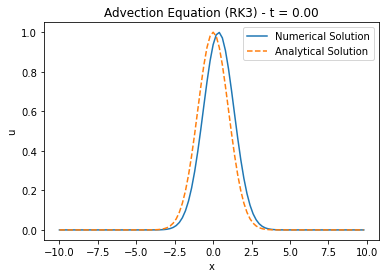

In [4]:
u = RK3(u, dx, dt, Nx)
#PLOT ANIMATION
fig, ax = plt.subplots()
line, = ax.plot(x, u, label="Numerical Solution")
analytical_line, = ax.plot(x, analytical_solution(x, 0), "--", label="Analytical Solution")
ax.set_title('Advection Equation (RK3)')
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.legend()

# Update function for animation
def update(frame):
    global u
    u = RK3(u,dx,dt, Nx)
    line.set_ydata(u)
    analytical_line.set_ydata(analytical_solution(x, frame*dt))
    ax.set_title(f'Advection Equation (RK3) - t = {frame*dt:.2f}')
    return line, analytical_line

# Create animation
animation = FuncAnimation(fig, update, frames=Nt, interval=50, blit=True)
HTML(animation.to_html5_video())


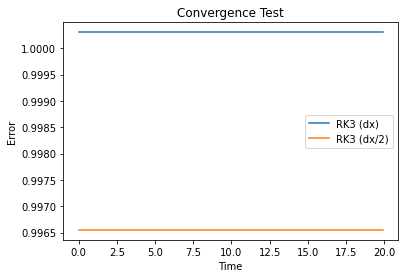

In [33]:
#CONVERGENCE.
time_points = []
errors1 = []
errors2 = []
T = dt * Nt
for _ in range(int(T / dt)):
    # RK3 with full spatial resolution
    u1 = RK3(u, dx, dt, Nx)
    error1 = np.max(np.abs(u1 - analytical_solution(x, T)))
    errors1.append(error1)

    # RK3 with half spatial resolution
    u2 = RK3(u, dx / 2, dt, Nx)
    error2 = np.max(np.abs(u2 - analytical_solution(x, T)))
    errors2.append(error2)

    # Update time
    time_points.append(_ * dt)

# Plotting the errors over time
plt.plot(time_points, errors1, label='RK3 (dx)', linestyle='-')
plt.plot(time_points, errors2, label='RK3 (dx/2)', linestyle='-')

plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Convergence Test')
plt.legend()
plt.savefig("convergence.png", dpi=300)
plt.show()


## WAVE EQUATION

$\partial_t^2u=c^2\nabla^2u $

Use system of equations:

$\partial_t u=v$

$\partial_t v=c^2\nabla^2u$

In this case we are going to use maximally disspative boundary conditions for the left and right limit:

$\partial_tu-c\partial_xu=0$

$\partial_tu+c\partial_xu=0$

In [5]:
# Initialize grid
L = 10.0    # Length of the domain
c = 1.0     # Advection velocity
Nx = 100    # Number of spatial grid points
Nt = 200    # Number of time steps
CFL = 0.7    # condition necessary for convergence
dx = 2*L / Nx  # Spatial step size
dt = CFL * dx
epsilon = 1
A = 1
sigma = 1
def initial_condition(x, A, sigma):
    return A * np.exp(-x**2 / (2 * sigma**2))
x = np.linspace(-L, L, Nx, endpoint=False)
u = initial_condition(x, A, sigma)
v = np.zeros(Nx)

def boundary_conditions(u,v):
    v[0] = c * (-48 * u[0] + 59 * u[1] - 8 * u[2] - 3 * u[3]) / (34 * dx)
    v[-1] = -c * (48 * u[-1] - 59 * u[-2] + 8 * u[-3] + 3 * u[-4]) / (34 * dx) 
    return v
 
def rhs(u,Nx,dx):#dx2
    rhs = np.zeros_like(u)
    for i in range(Nx):
        rhs[i] = (-u[(i+2)%Nx]+16*u[(i+1)%Nx]-30*u[i]+16*u[(i-1)%Nx]-u[(i-2)%Nx])/(12*dx*dx)
    return rhs

def RK3_wave(u, v, dx, dt, Nx):
    u_new = np.zeros_like(u)
    v_new = np.zeros_like(u)
    u_temp = np.copy(u)
    v_temp = np.copy(v)
    # Compute the spatial derivative and dissipation term at the current time step
    rhs_un = rhs(u_temp, Nx, dx) + dissipation_term(u_temp,dx,Nx,epsilon)
    rhs_vn = rhs(v_temp, Nx, dx) + dissipation_term(v_temp,dx,Nx,epsilon)
    # First stage of RK3 method
    u1 = (u_temp + dt * rhs_un)
    v1 = (v_temp + dt * rhs_vn)
    v1 = boundary_conditions(u1,v1)
    rhs_u1 = rhs(u1, Nx, dx)+ dissipation_term(u1,dx,Nx,epsilon)
    rhs_v1 = rhs(v1,Nx,dx) + dissipation_term(v1,dx,Nx,epsilon)
    # Second stage of RK3 method
    u2 = (u_temp + dt * (rhs_un + rhs_u1) / 4) 
    v2 = (v_temp + dt * (rhs_vn + rhs_v1) / 4) 

    v2 = boundary_conditions(u2,v2)
    rhs_u2 = spatial_derivative_4_order(u2, Nx, dx)+ dissipation_term(u2,dx,Nx,epsilon)
    # Final stage using the weighted average of the three evaluations
    u_new = u + (dt / 6.0) * (rhs_un + rhs_u1 + 4 * rhs_u2)
    v_new = boundary_conditions(u_new,v_new)
#     u1 = u_temp + dt * (rhs(u,Nx,dx) + dissipation_term(u,dx,Nx,epsilon))
#     v1 = v_temp + dt * (rhs(v,Nx,dx) + dissipation_term(v,dx,Nx,epsilon))
#     v1 = boundary_conditions(u1,v1)
#     u2 = u_temp + dt * ((rhs(u,Nx,dx) + rhs(u1,Nx,dx)) / 4 + dissipation_term(u,dx,Nx,epsilon))
#     v2 = v_temp + dt * ((rhs(v,Nx,dx) + rhs(v1,Nx,dx)) / 4 + dissipation_term(v,dx,Nx,epsilon))
#     v2 = boundary_conditions(u2,v2)
#         # Update using the weighted average of the three evaluations
#     u_new = u_temp + (dt / 6.0) * ((rhs(u,Nx,dx)+ dissipation_term(u,dx,Nx,epsilon)) + 
#                                              (rhs(u1,Nx,dx)+ dissipation_term(u,dx,Nx,epsilon)) + 
#                                              4 *(rhs(u2,Nx,dx)+ dissipation_term(u,dx,Nx,epsilon)))
#     v_new = v_temp + (dt / 6.0) * ((rhs(v,Nx,dx)+ dissipation_term(u,dx,Nx,epsilon)) + 
#                                              (rhs(v1,Nx,dx)+ dissipation_term(u,dx,Nx,epsilon)) + 
#                                              4 * (rhs(v2,Nx,dx)+ dissipation_term(u,dx,Nx,epsilon)))
#     v_new = boundary_conditions(u_new, v_new)  # Apply boundary conditions to the final result
    return u_new, v_new

def analytical_solution_wave(x, t):
    wave_1 = initial_condition(x - c * t, A, sigma)  # Forward-moving wave
    wave_2 = initial_condition(x + c * t, A, sigma)  # Backward-moving wave
    return 0.5 * (wave_1 + wave_2)

RuntimeError: Requested MovieWriter (ffmpeg) not available

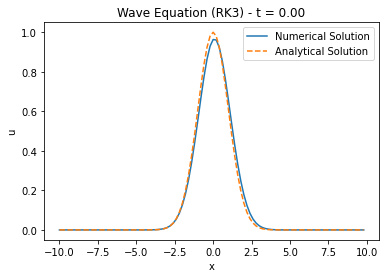

In [6]:
fig, ax = plt.subplots()
#initial_line, = ax.plot(x, u, color='gray', linestyle='--', label='Condición inicial')
line, = ax.plot(x, u, label="Numerical Solution")
analytical_line, = ax.plot(x, analytical_solution_wave(x, 0), "--", label="Analytical Solution")

ax.set_title('Wave Equation (RK3)')
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.legend()

# Update function for animation
def update(frame):
    global u_new, u, v
    u_new, v_new = RK3_wave(u, v, dx, dt, Nx)
    u = np.copy(u_new)
    v = np.copy(v_new)
    line.set_ydata(u)
    analytical_line.set_ydata(analytical_solution_wave(x, frame * dt))
    ax.set_title(f'Wave Equation (RK3) - t = {frame*dt:.2f}')
    return line, analytical_line
# Create animation
wave_animation = FuncAnimation(fig, update, frames= Nt, interval=100, blit=True)
HTML(wave_animation.to_html5_video())
